In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.fftpack import  fft, ifft, ifftshift
from scipy.signal import correlate
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

In [3]:
save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/all_reseed_results"

In [5]:
wake_ret = pd.read_pickle(os.path.join(save_dir, '240.0_pred_rets'))

In [7]:
for ret in [wake_ret]:
    break

In [53]:

reseeds = list(ret.keys())
models = list(ret[reseeds[0]].keys())
stats = list(ret[reseeds[0]][models[0]].keys())

iterator = tqdm(total=len(reseeds)*len(models)*len(stats))
metric_vals = {}
for reseed in reseeds:
    metric_vals[reseed] = {}
    for model in models:
        if model != 'true':
            metric_vals[reseed][model] = {}
            for stat in stats:
                metric_vec = dict(
                    correl=np.zeros(ret[reseed][model][stat].shape[0]),
                    mse=np.zeros(ret[reseed][model][stat].shape[0])
                )
                for i in range(ret[reseed][model][stat].shape[0]):
                    a = ret[reseed][model][stat][i]
                    b = ret[reseed]['true'][stat][i]
#                         correl_vec[i] = scipy.stats.spearmanr(a, b).correlation
                    if stat == 'correl_mats':
                        metric_vec['correl'][i] = np.corrcoef(a.flatten(), b.flatten())[0, 1]
#                             correl_vec[i] = r2_score(a.flatten(), b.flatten())
                    else:
                        metric_vec['correl'][i]  = np.corrcoef(a, b)[0, 1]
#                             correl_vec[i] = r2_score(a, b)
                    metric_vec['mse'][i]  = ((a - b)**2).mean()

                metric_vals[reseed][model][stat] = metric_vec
                iterator.update()
        else:
            iterator.update(len(stats))
        
iterator.close()

  0%|          | 0/360 [00:00<?, ?it/s]

In [54]:
metrics = ['mse', 'correl']

In [62]:
curves = {}
for model in models:
    curves[model] = {}
    if model != 'true':
        for stat in stats:
            curves[model][stat] = {}
            for metric in metrics:
                curves[model][stat][metric] = dict(
                    mean=np.array([metric_vals[reseed][model][stat][metric].mean() for reseed in reseeds]),
                    se=np.array([compute_se(metric_vals[reseed][model][stat][metric]) for reseed in reseeds])
                )

<ErrorbarContainer object of 3 artists>

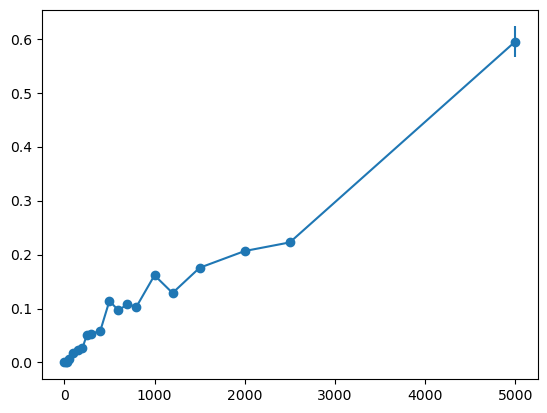

In [74]:
curves[model][stat][metric]['se']

array([2.83253794e-09, 1.46918268e-05, 6.33181244e-05, 9.25279126e-04,
       1.36203011e-03, 1.56526210e-03, 2.14623532e-03, 1.38918436e-03,
       2.85181742e-03, 4.47239480e-03, 1.44686519e-03, 5.94881630e-03,
       2.29094893e-03, 4.26312171e-03, 2.41940338e-03, 5.73753830e-03,
       3.55561100e-03, 4.92953502e-03, 1.13775808e-02,            nan])

In [75]:
curves[model][stat][metric]['mean'],

(array([4.78419397e-08, 3.04413170e-04, 1.43385903e-03, 5.56053766e-03,
        1.70157563e-02, 1.77139525e-02, 2.55060865e-02, 4.27647110e-02,
        4.81172694e-02, 8.44359432e-02, 1.10317436e-01, 1.33120206e-01,
        7.78786065e-02, 1.08013938e-01, 1.80104732e-01, 2.02653247e-01,
        2.44321852e-01, 3.86004563e-01, 8.90810634e-01,            nan]),)

In [90]:
model_colors = dict(
    true='C0',
    havok='C1',
    havok_big='C2',
    VAR='C3',
    VAR_small='C4',
    PB='grey'
)

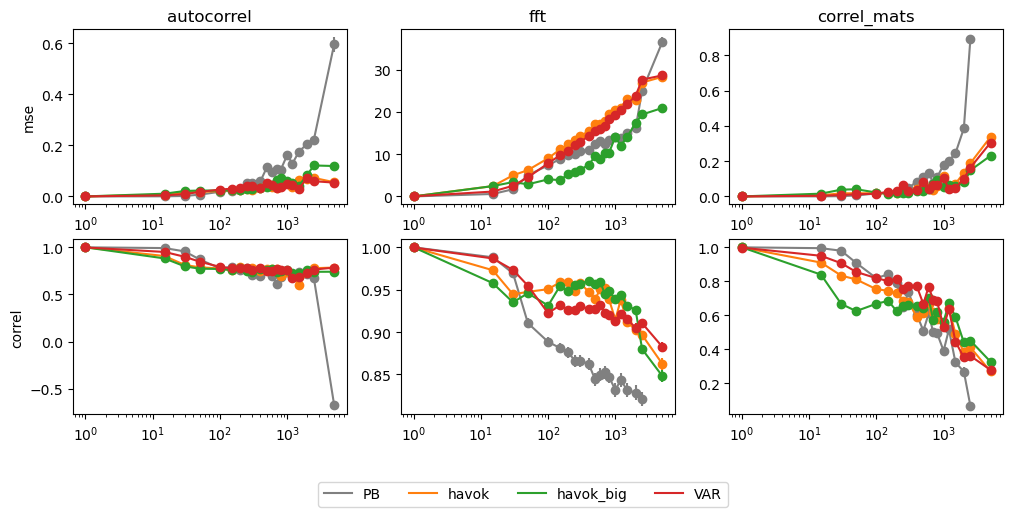

In [93]:
fig, axs = plt.subplots(len(metrics), len(stats), figsize=(12, 5))

for i, metric in enumerate(metrics):
    for j, stat in enumerate(stats):
        ax = axs[i][j]
        for model in models:
            if model != 'true' and model != 'VAR_small':
                filter_vals = ~np.isnan(curves[model][stat][metric]['mean'])
                ax.errorbar(np.array(reseeds)[filter_vals], curves[model][stat][metric]['mean'][filter_vals], yerr=curves[model][stat][metric]['se'][filter_vals], color=model_colors[model], marker='o')
#                 ax.scatter(reseeds, curves[model][stat][metric]['mean'], linestyle='-', yerr=curves[model][stat][metric]['se'])
        
        ax.set_xscale('log')
        
        if i == 0:
            ax.set_title(stat)
        if j == 0:
            ax.set_ylabel(metric)
lns = []
for model in models:
    if model != 'true' and model != 'VAR_small':
        lns += plt.plot([], label=model, c=model_colors[model])
        labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=4)
plt.show()